In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
#Regression Packages
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, cross_val_predict
import statsmodels.formula.api as smf
#from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn import neighbors
from sklearn import ensemble
#from sklearn.svm import SVR


In [59]:
class createSet(object): # Make this subclass pd dataframe? #https://stackoverflow.com/questions/22155951/how-to-subclass-pandas-dataframe
    '''This creates pandas dataframe of a specified size with generated features of
    various distributions and a dependent variable of a specified skewness. 
    
    This class also has a few methods for creating additional, completely random features with 
    a function call. These can be of specified distribution but are truly random and are likely
    to have correlations close to zero with the target variable.
    
    The outlier method removes rows at random and replaces them with outliers: use "all" to get
    extreme values in every column, or specify 'columns=[]' to get outliers in only some features.
    '''
    
    def __init__(self,size=10000, targetskew=0, corr=0.5, multicol=0.0):
        self.size = size
        
        #create a baseline dataset with the correlations we want. This creates a series 
        #with mean zero and std=1 and the correlations specified by the covariance matrix (cov=)
        mvnorm = stats.multivariate_normal(mean=[0, 0, 0, 0], cov=[[1., corr, corr, corr], 
                                                                  [corr, 1., multicol, multicol],
                                                                  [corr, multicol, 1., multicol],
                                                                  [corr, multicol, multicol, 1.]])
        raw = mvnorm.rvs(self.size)
        #create the target variable with the specified targetskew
        targetMean = 3000 #based on my own average of ~50 hours/month
        targetStd = 1000 #guess
        
        if targetskew:
            self.standardNormalTarget =  raw[:,0]
            intendedSortOrder = stats.rankdata(self.standardNormalTarget, method='ordinal')
            sortedSkew = np.sort(stats.skewnorm.rvs(a=targetskew, loc=targetMean,scale=targetStd, size=self.size))
            self.minSpent = [sortedSkew[i-1] for i in intendedSortOrder]
            df = pd.DataFrame(self.minSpent, columns=['minSpent'])
        else:
            self.standardNormalTarget =  raw[:,0]
            intendedSortOrder = stats.rankdata(self.standardNormalTarget, method='ordinal')
            self.minSpent = self.standardNormalTarget*targetStd + targetMean
            df = pd.DataFrame(self.minSpent, columns=['minSpent'])
        
        #Some of the features will be calculated using the target variable to artificially create some
        # correlation. However, I don't want them to automatically inherit the skewness of the target
        # variable, so instead of basing the independing variables directly on the target, I will 
        # create a normal distribution on the same scale that is sorted to match the order of the 
        # target variable. That enables creating correlated features without inheriting skew.
        
        
        #This adds a normally distributed feature with the correlations specified by the 2nd column of (cov=)
        #The std (3K) and mean (12K) are arbitrarily chosen to make the data intuitive (few/no negatives)
        df['screenActions'] = raw[:,1]*3000
        df['screenActions'] = df.screenActions - min(0,df.screenActions.min())
        df['screenActions'].astype('int') 

        #This adds a left-tailed skewed distributed feature with the correlations specified by the 3rd column of (cov=)
        #mean based on 2 pics per day for 30 days
        picSkew = np.sort(stats.skewnorm.rvs(a=-5, loc=60,scale=15, size=self.size))
        picSortOrder = stats.rankdata(raw[:,2], method='ordinal')
        df['picsTaken'] = [picSkew[i-1] for i in picSortOrder]
        df['picsTaken'] = df['picsTaken'].astype('int') 

        #This adds a right-tailed skewed distribution for owner's age        
        ageSkew = np.sort(stats.skewnorm.rvs(a=5, loc=25,scale=15, size=self.size))
        ageSortOrder = stats.rankdata(raw[:,3], method='ordinal')
        df['ownerAge'] = [ageSkew[i-1] for i in ageSortOrder]


        
        #This adds a poisson distribution that's typically around .17 correlation
        df['timesDropped'] = [np.random.poisson(lam=1.5) if x > 0 else 
                              np.random.poisson(lam=1.0) for x in self.standardNormalTarget]


        #This adds a bernoulli distribution for whether the phone is rooted, typically around .06 correlation
        df['rooted'] = [np.random.binomial(1, .05) if x > 0 else
                        np.random.binomial(1, .005) for x in self.standardNormalTarget]

        #This adds a categorical variable that slightly corresponds to the target
        def osChoice(self, p):
            return np.random.choice(a=['iOS', 'Android', 'other'], p=p)
        df['os'] = [osChoice(self,[.415,.575,.01]) if x > targetMean else 
                               osChoice(self,[.335,.635,.03]) for x in self.standardNormalTarget]
               
        self.df = df
        
    def addContFeatures(self, feats={'normal':1}):
        for shape, cnt in feats.items():
            if shape == 'normal':
                for j in range(cnt):
                    Y = np.random.normal(loc=targetMean,scale=targetStd, size=self.size)
                    self.df['normalFeat_'+str(self.cons)] = Y
                    self.cons=self.cons+1
            elif shape == 'uniform':
                for j in range(cnt):
                    Y = np.random.uniform(size=self.size)*(targetMean*2)
                    self.df['uniformFeat_'+str(self.cons)] = Y
                    self.cons=self.cons+1
            elif shape == 'poisson':
                for j in range(cnt):
                    Y = np.random.poisson(lam=1.0,size=self.size)
                    self.df['poissonFeat_'+str(self.cons)] = Y
                    self.cons=self.cons+1
            elif shape == 'gamma':
                for j in range(cnt):
                    Y = np.random.gamma(shape=2.0,scale=2,size=self.size)
                    self.df['gammaFeat_'+str(self.cons)] = Y
                    self.cons=self.cons+1
                    
                
            else:
                print('NOTE: received invalid distribution type. Try \"normal\", \"uniform\", or ')
    
    def addCatFeatures(self, feats={'sex':['male', 'female']}):
        for name, values in feats.items():
            odds = np.random.randint(low=0, high=len(values),size=self.size)
            self.df[name] = [values[x] for x in odds]
            del odds
            
    def addOutliers(self, cnt=5):
        #code this
        self.df = df
        
        
        
            
        

In [60]:
#this cell doesn't need to run; It checks 100 iterations of the class createSet() to see how the features
# tend to correlate with the target variable (given that they are generated dynamically)
#It's only useful when I update how a feature is calculated

import time
start = time.time()
screencorrs = []
picscorrs = []
dropscorrs = []
agecorrs = []
rootcorrs = []
for i in range(100):
    u = createSet(size=1000)
    cor = u.df.corr()
    screencorrs.append(cor.loc['minSpent','screenActions'])
    picscorrs.append(cor.loc['minSpent','picsTaken'])
    dropscorrs.append(cor.loc['minSpent','timesDropped'])
    agecorrs.append(cor.loc['minSpent','ownerAge'])
    rootcorrs.append(cor.loc['minSpent','rooted'])
print('Correlations: \n')
print('screenActions (Normal Variable)\n',np.mean(screencorrs),'\n', np.std(screencorrs), '\n')
print('picsTaken (Skewed Variable) \n',np.mean(picscorrs),'\n', np.std(picscorrs), '\n')
print('timesDropped (Poisson Variable) \n',np.mean(dropscorrs),'\n', np.std(dropscorrs), '\n')
print('ownerAge (Skewed Variable) \n',np.mean(agecorrs),'\n', np.std(agecorrs), '\n')
print('rooted (Bernoulli Variable)\n',np.mean(rootcorrs),'\n', np.std(rootcorrs), '\n')
print('done in ', time.time() - start, 'seconds')
u.df.corr()

Correlations: 

screenActions (Normal Variable)
 0.49939214963727474 
 0.0240574510610771 

picsTaken (Skewed Variable) 
 0.48740064062935773 
 0.021095384989635063 

timesDropped (Poisson Variable) 
 0.17043041199215833 
 0.031468239571747623 

ownerAge (Skewed Variable) 
 0.49069373272339506 
 0.026103230088547636 

rooted (Bernoulli Variable)
 0.11359482634750792 
 0.025477327234859105 

done in  3.03456974029541 seconds


,minSpent,screenActions,picsTaken,ownerAge,timesDropped,rooted
minSpent,1.000000,0.504966,0.478980,0.456301,0.124880,0.117610
screenActions,0.504966,1.000000,0.012375,-0.010748,0.090283,0.027312
picsTaken,0.478980,0.012375,1.000000,-0.020723,0.032020,0.073889
ownerAge,0.456301,-0.010748,-0.020723,1.000000,0.090040,0.116452
timesDropped,0.124880,0.090283,0.032020,0.090040,1.000000,0.045450
rooted,0.117610,0.027312,0.073889,0.116452,0.045450,1.000000


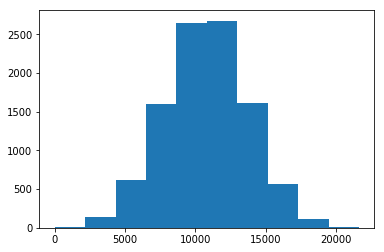

minSpent        -836.461
screenActions          0
picsTaken              0
ownerAge         20.7792
timesDropped           0
rooted                 0
os               Android
dtype: object

minSpent         6452.76
screenActions      21619
picsTaken             62
ownerAge         82.4869
timesDropped           7
rooted                 1
os                 other
dtype: object

In [55]:
u = createSet(size=10000)
plt.hist(u.df.screenActions)
plt.show()
display(u.df.min())
display(u.df.max())

---------------------------------------------------------------------------

---------------------------------------------------------------------------

---------------------------------------------------------------------------

---------------------------------------------------------------------------

_________________

In [61]:
#Let's create one for vizualization

viz = createSet(targetskew=0)
print(viz.df.shape)
display(viz.df.head())
viz.df.corr()

(10000, 7)


,minSpent,screenActions,picsTaken,ownerAge,timesDropped,rooted,os
0,1818.083757,10235.019387,51,46.399434,0,0,iOS
1,1610.387599,11234.003853,33,23.894528,0,0,iOS
2,2750.602778,5244.548942,53,45.955117,0,0,Android
3,2696.657189,8459.397048,57,30.946791,0,0,iOS
4,2979.345873,7894.345315,45,36.843712,2,0,Android


,minSpent,screenActions,picsTaken,ownerAge,timesDropped,rooted
minSpent,1.000000,0.502547,0.489595,0.487413,0.175213,0.117838
screenActions,0.502547,1.000000,0.006978,-0.007368,0.085324,0.040507
picsTaken,0.489595,0.006978,1.000000,-0.003596,0.093608,0.058290
ownerAge,0.487413,-0.007368,-0.003596,1.000000,0.089417,0.060021
timesDropped,0.175213,0.085324,0.093608,0.089417,1.000000,0.022497
rooted,0.117838,0.040507,0.058290,0.060021,0.022497,1.000000


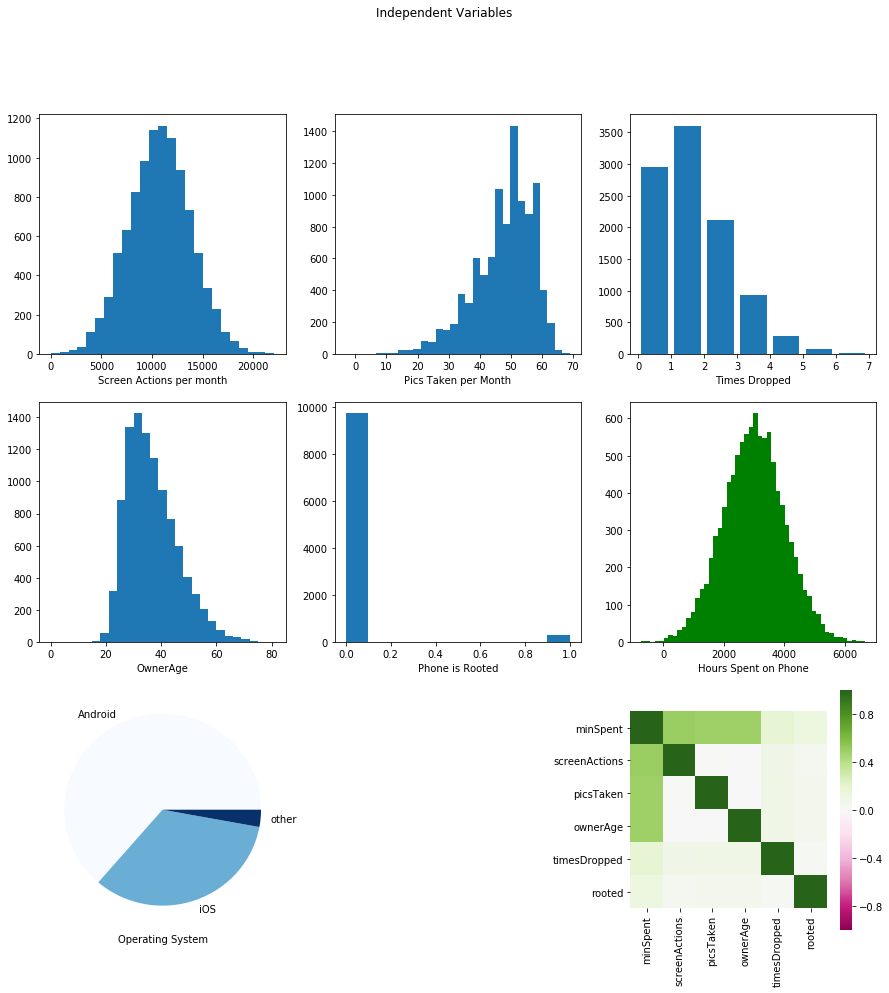

In [106]:
#Core feature Histograms

plt.figure(figsize=(15,15))
plt.suptitle('Independent Variables')
plt.subplot(331)
plt.hist(viz.df.screenActions, bins=25)
plt.xlabel('Screen Actions per month')
plt.subplot(332)
plt.hist(viz.df.picsTaken, bins=30)
plt.xlabel('Pics Taken per Month')
plt.subplot(333)
plt.hist(viz.df.timesDropped, bins=np.arange(0,max(viz.df.timesDropped),1), rwidth = .8)
plt.xlabel('Times Dropped')
plt.subplot(334)
plt.hist(viz.df.ownerAge, bins=np.arange(0,max(viz.df.ownerAge),3))
plt.xlabel('OwnerAge')
plt.subplot(335)
plt.hist(viz.df.rooted)#, bins=np.arange(0,40,3))
plt.xlabel('Phone is Rooted')
plt.subplot(336)
plt.hist(viz.df.minSpent, color='g', bins=50)#, bins=np.arange(0,40,3))
plt.xlabel('Hours Spent on Phone')
plt.ylabel('')
plt.subplot(337)
viz.df['os'].value_counts().plot(kind='pie')
plt.ylabel('')
plt.xlabel('Operating System')
plt.subplot(339)
sns.heatmap(viz.df.corr(), vmin = -1,square=True, cmap="PiYG")
plt.show()

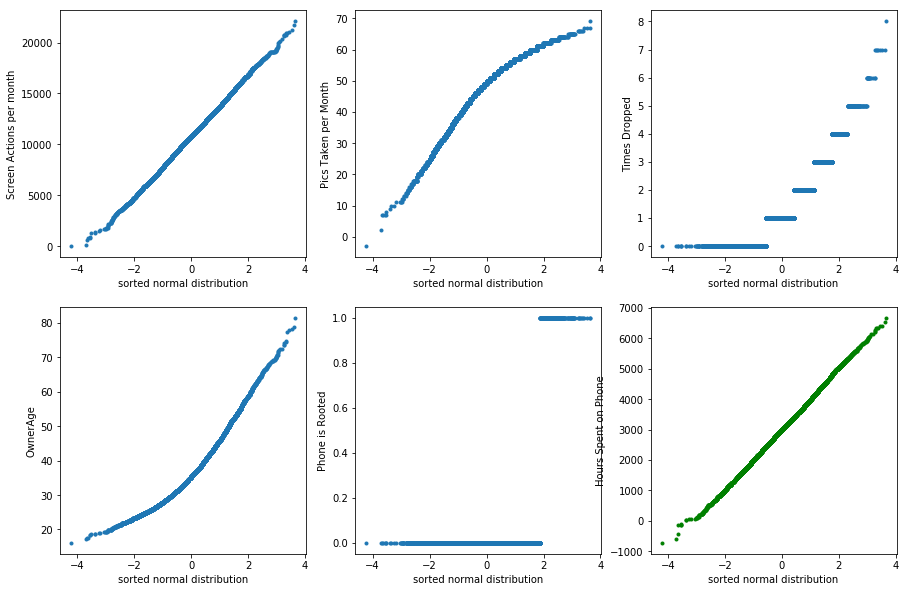

In [63]:
#Quartile Plot compared to random normal

norm = np.random.normal(0, 1, viz.size)
norm.sort()
norm1 = viz.df['screenActions'].sort_values()
uni2 =  viz.df['picsTaken'].sort_values()
pois3 =  viz.df['timesDropped'].sort_values()
gamma4 = viz.df['ownerAge'].sort_values()
bern = viz.df['rooted'].sort_values()
target = viz.df['minSpent'].sort_values()

plt.figure(figsize=(15,10))
plt.subplot(231)
plt.plot(norm, norm1, ".")
plt.xlabel('sorted normal distribution')
plt.ylabel('Screen Actions per month')
plt.subplot(232)
plt.plot(norm, uni2, ".")
plt.ylabel('Pics Taken per Month')
plt.xlabel('sorted normal distribution')
plt.subplot(233)
plt.plot(norm, pois3, ".")
plt.ylabel('Times Dropped')
plt.xlabel('sorted normal distribution')
plt.subplot(234)
plt.plot(norm, gamma4, ".")
plt.ylabel('OwnerAge')
plt.xlabel('sorted normal distribution')
plt.subplot(235)
plt.plot(norm, bern, ".")
plt.ylabel('Phone is Rooted')
plt.xlabel('sorted normal distribution')
plt.subplot(236)
plt.plot(norm, target, "g.")
plt.ylabel('Hours Spent on Phone')
plt.xlabel('sorted normal distribution')
plt.show()

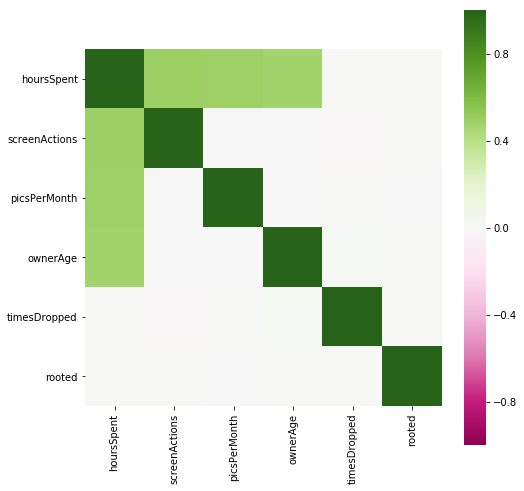

In [8]:
plt.figure(figsize=[8,8])
sns.heatmap(viz.df.corr(), vmin = -1,square=True, cmap="PiYG")
plt.show()

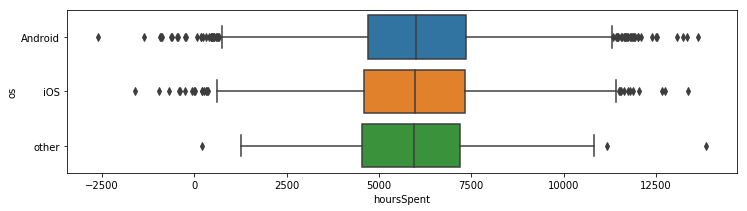

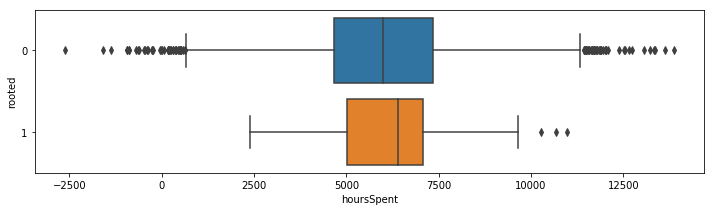

In [9]:
plt.figure(figsize=[12,3])
sns.boxplot(x='minSpent', y='os', data=viz.df, orient='h')
plt.show()
plt.figure(figsize=[12,3])
sns.boxplot(x='minSpent', y='rooted', data=viz.df, orient='h')
plt.show()

# Baseline: Linear Regression of a normally distributed dependent variable using 1 normally distributed feature

In [105]:
normal = createSet(targetskew=0, size=10000)
regr = linear_model.LinearRegression()

In [12]:
#sklearn
x = normal.df['screenActions']
y = normal.df['minSpent']
regr.fit(pd.DataFrame(x),y)
scores = cross_val_score(regr,pd.DataFrame(x),y,cv=10)
print("Fold Scores: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\nCoefficients:', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\n','-'*40)

#statsmodels

linear_formula = 'minSpent ~ screenActions'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=normal.df).fit()
lm.summary()

Fold Scores:  [0.22565264 0.24726738 0.2485579  0.2660633  0.20872428 0.24618141
 0.28688758 0.25849828 0.27361258 0.25443091]

Average Score:  0.2515876274193267

Coefficients: [0.33816728]

Intercept: 
 1979.7202182111305

 ----------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             hoursSpent   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     3385.
Date:                Fri, 28 Dec 2018   Prob (F-statistic):               0.00
Time:                        12:00:57   Log-Likelihood:                -88782.
No. Observations:               10000   AIC:                         1.776e+05
Df Residuals:                    9998   BIC:                         1.776e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1979.7202     72.066     27.471      0.000    1838.457    2120.984
screenActions     0.3382      0.006     58.177      0.000       0.327       0.350
==============================================================================
Omnibus:                        3.939   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.139   Jarque-Bera (JB):                3.717
Skew:                           0.009   Prob(JB):                        0.156
Kurtosis:                       2.907   Cond. No.                     5.15e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.15e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

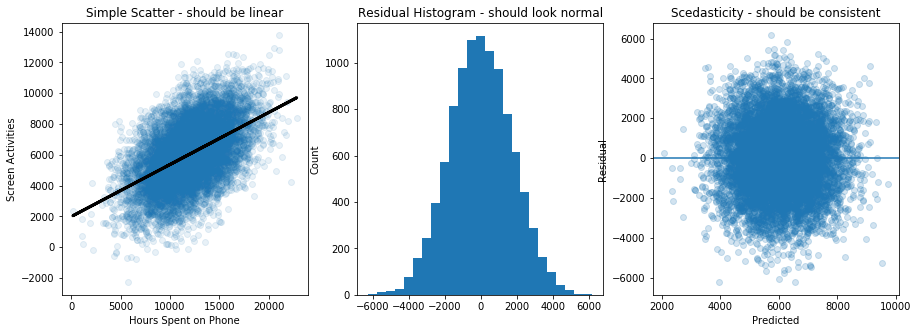

In [13]:
#Let's check how our output looks:
pred = cross_val_predict(regr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.scatter(x,y, alpha=.1)
plt.plot(x, regr.predict(pd.DataFrame(x)), color='black', linewidth=3)
plt.title('Simple Scatter - should be linear')
plt.xlabel('Hours Spent on Phone')
plt.ylabel('Screen Activities')
plt.subplot(132)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')
plt.show()
#annotate charts? sample#, output std, modeled std

# What if the target variable had a right skew instead of being normally distributed?

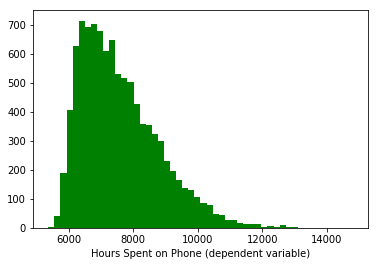

In [14]:
rightskew = createSet(targetskew=10, size=10000)
plt.hist(rightskew.df.minSpent, color='g', bins=50)
plt.xlabel('Hours Spent on Phone (dependent variable)')
plt.show()

regr = linear_model.LinearRegression()

In [15]:
#sklearn
x = rightskew.df['screenActions']
y = rightskew.df['minSpent']
regr.fit(pd.DataFrame(x),y)
scores = cross_val_score(regr,pd.DataFrame(x),y,cv=10)
print("Fold Scores: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\nCoefficients:', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\n','-'*40)
#statsmodels

linear_formula = 'minSpent ~ screenActions'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=rightskew.df).fit()
lm.summary()

Fold Scores:  [0.2814143  0.24964971 0.25961466 0.24775937 0.23330729 0.2329133
 0.21499702 0.23177933 0.2384756  0.20994886]

Average Score:  0.23998594552917868

Coefficients: [0.19924201]

Intercept: 
 5208.662976517212

 ----------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             hoursSpent   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     3179.
Date:                Fri, 28 Dec 2018   Prob (F-statistic):               0.00
Time:                        12:00:58   Log-Likelihood:                -83793.
No. Observations:               10000   AIC:                         1.676e+05
Df Residuals:                    9998   BIC:                         1.676e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5208.6630     43.415    119.974      0.000    5123.561    5293.765
screenActions     0.1992      0.004     56.386      0.000       0.192       0.206
==============================================================================
Omnibus:                      997.848   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1377.037
Skew:                           0.804   Prob(JB):                    9.56e-300
Kurtosis:                       3.847   Cond. No.                     5.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

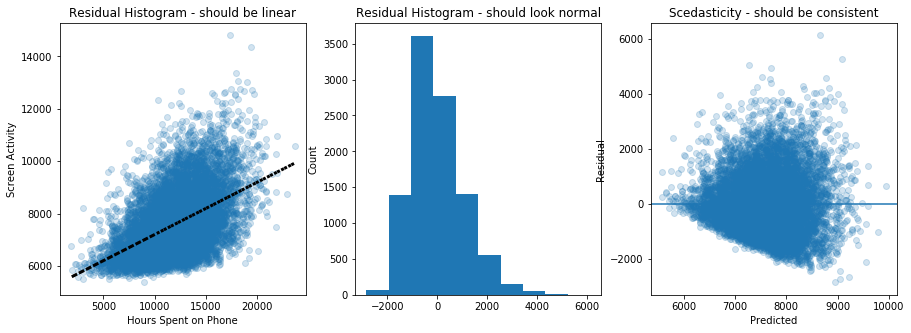

In [16]:
#Let's check how our output looks:
pred = cross_val_predict(regr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.scatter(x,y, alpha=.2)
plt.plot(x, regr.predict(pd.DataFrame(x)), color='black', lw=3, ls='dotted')
plt.title('Residual Histogram - should be linear')
plt.xlabel('Hours Spent on Phone')
plt.ylabel('Screen Activity')
plt.subplot(132)
plt.hist(residual)
plt.title('Residual Histogram - should look normal')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')
plt.show()

In [17]:
# If we use a transformation to reduce the skew, how much does it help?

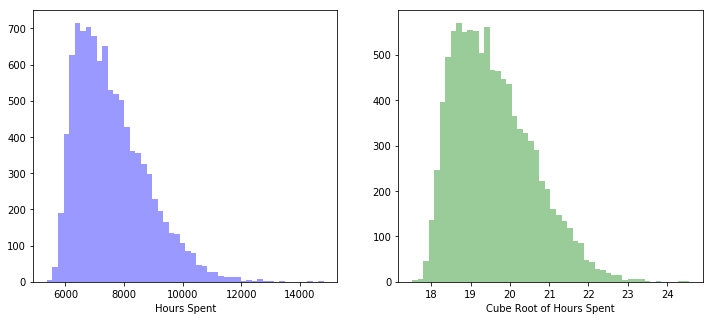

In [18]:
plt.figure(figsize=[12,5])
plt.subplot(121)
plt.hist(rightskew.df.minSpent, color='b', bins=50, alpha=.4)
plt.xlabel('Hours Spent')
plt.subplot(122)
plt.hist(rightskew.df.minSpent**(1/3), color='g', bins=50, alpha=.4)
plt.xlabel('Cube Root of Hours Spent')
plt.show()

In [19]:
rightskew.df['cube_rt_minSpent'] = rightskew.df['minSpent']**(1/3)
y = rightskew.df['cube_rt_minSpent']
regr.fit(pd.DataFrame(x),y)
scores = cross_val_score(regr,pd.DataFrame(x),y,cv=10)
print("Fold Scores: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\nCoefficients:', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\n','-'*40)
#statsmodels

linear_formula = 'cube_rt_minSpent ~ screenActions'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=rightskew.df).fit()
lm.summary()

Fold Scores:  [0.28946182 0.25789322 0.26288051 0.25584106 0.24142931 0.23685782
 0.22102433 0.23732928 0.24137913 0.21645812]

Average Score:  0.24605545948220872

Coefficients: [0.00016837]

Intercept: 
 17.58728275311564

 ----------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     cube_rt_hoursSpent   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     3286.
Date:                Fri, 28 Dec 2018   Prob (F-statistic):               0.00
Time:                        12:00:59   Log-Likelihood:                -12867.
No. Observations:               10000   AIC:                         2.574e+04
Df Residuals:                    9998   BIC:                         2.575e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        17.5873      0.036    487.344      0.000      17.517      17.658
screenActions     0.0002   2.94e-06     57.325      0.000       0.000       0.000
==============================================================================
Omnibus:                      484.664   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              556.531
Skew:                           0.572   Prob(JB):                    1.42e-121
Kurtosis:                       3.165   Cond. No.                     5.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

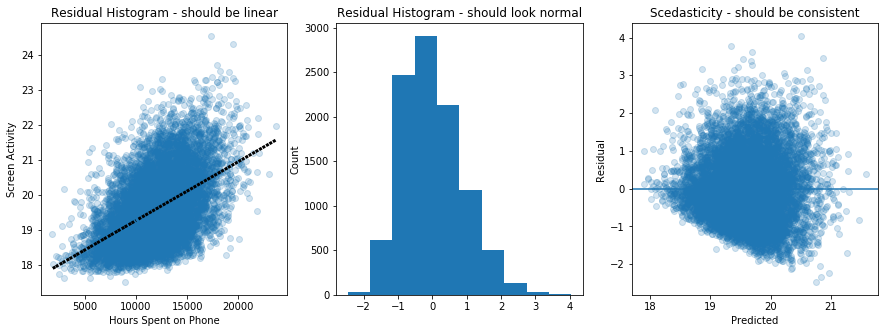

In [20]:
#Let's check how our output looks:
pred = cross_val_predict(regr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.scatter(x,y, alpha=.2)
plt.plot(x, regr.predict(pd.DataFrame(x)), color='black', lw=3, ls='dotted')
plt.title('Residual Histogram - should be linear')
plt.xlabel('Hours Spent on Phone')
plt.ylabel('Screen Activity')
plt.subplot(132)
plt.hist(residual)
plt.title('Residual Histogram - should look normal')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')
plt.show()

# How do other types of regressors do?

In [22]:
print("NORMAL:\n")
x = normal.df['screenActions']
y = normal.df['minSpent']
knn = neighbors.KNeighborsRegressor(n_neighbors=30)
knn.fit(pd.DataFrame(x),y)
scores = cross_val_score(knn,pd.DataFrame(x),y,cv=10)
print("KNN: ",scores)
print("\nAverage Score with 30 neighbors: ",np.mean(scores))
print('\n','-'*40)

rfr = ensemble.RandomForestRegressor(n_estimators=10, max_depth=3)
rfr.fit(pd.DataFrame(x),y)
scores = cross_val_score(rfr,pd.DataFrame(x),y,cv=10)
print("Random Forest Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

gbr = ensemble.GradientBoostingRegressor(loss='ls', learning_rate=.1, max_depth=2, n_estimators=100)
gbr.fit(pd.DataFrame(x),y)
scores = cross_val_score(gbr,pd.DataFrame(x),y,cv=10)
print("Gradient-Boosted Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)


#TOO SLOW:
# svm = SVR(kernel='linear')
# svm.fit(pd.DataFrame(x),y)
# scores = cross_val_score(svm,pd.DataFrame(x),y,cv=5)
# print("SVM Regressor: ",scores)
# print("\nAverage Score: ",np.mean(scores))
# print('\n','-'*40)

#add std of the folds

NORMAL:

KNN:  [0.18903789 0.22437027 0.22661445 0.25562312 0.1844479  0.22115537
 0.26746882 0.2383012  0.25308274 0.21518242]

Average Score with 30 neighbors:  0.22752841728686413

 ----------------------------------------
Random Forest Regressor:  [0.22267493 0.24539388 0.24737564 0.26783114 0.19794828 0.24247777
 0.28592888 0.26151534 0.27019364 0.25123663]

Average Score:  0.24925761297987012

 ----------------------------------------
Gradient-Boosted Regressor:  [0.21782636 0.24536281 0.24985428 0.26344194 0.20235856 0.24868942
 0.28603374 0.26141145 0.2711727  0.24930315]

Average Score:  0.2495454416987985

 ----------------------------------------


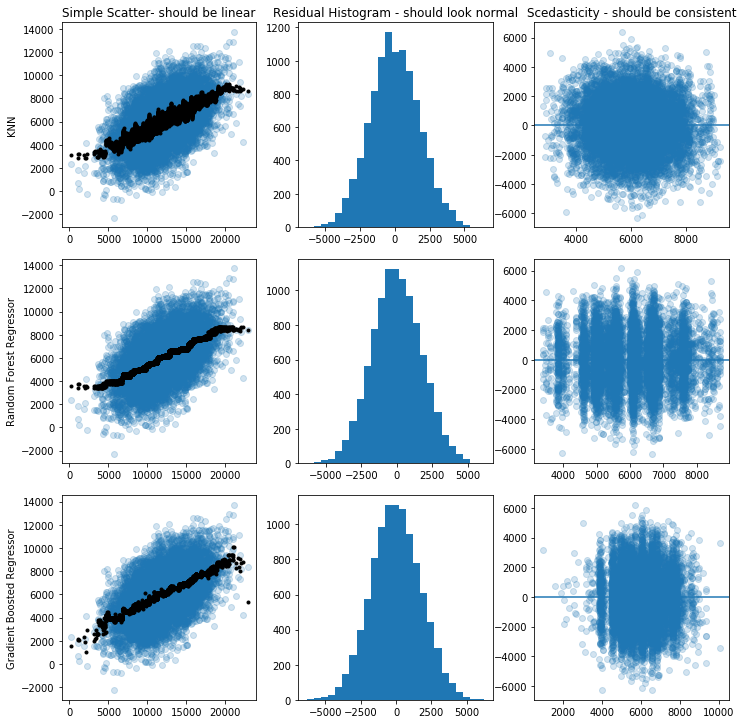

In [23]:
#Let's check how our output looks:
pred = cross_val_predict(knn,pd.DataFrame(x),y,cv=10)
residual = y - pred

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.tight_layout()
plt.subplot(331)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.title('Simple Scatter- should be linear')
plt.ylabel('KNN')
plt.subplot(332)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.subplot(333)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')

pred = cross_val_predict(rfr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(334)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Random Forest Regressor')
plt.subplot(335)
plt.hist(residual, bins=25)
plt.subplot(336)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

pred = cross_val_predict(gbr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(337)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Gradient Boosted Regressor')
plt.subplot(338)
plt.hist(residual, bins=25)
plt.subplot(339)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

plt.show()

In [24]:
# Skewed Target Variable:

print("SKEWED TARGET VARIABLE:\n")
x = rightskew.df['screenActions']
y = rightskew.df['minSpent']
knn = neighbors.KNeighborsRegressor(n_neighbors=30)
knn.fit(pd.DataFrame(x),y)
scores = cross_val_score(knn,pd.DataFrame(x),y,cv=10)
print("KNN: ",scores)
print("\nAverage Score with 30 neighbors: ",np.mean(scores))
print('\n','-'*40)

rfr = ensemble.RandomForestRegressor(n_estimators=10, max_depth=3)
rfr.fit(pd.DataFrame(x),y)
scores = cross_val_score(rfr,pd.DataFrame(x),y,cv=10)
print("Random Forest Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

gbr = ensemble.GradientBoostingRegressor(loss='ls', learning_rate=.1, max_depth=2, n_estimators=100)
gbr.fit(pd.DataFrame(x),y)
scores = cross_val_score(gbr,pd.DataFrame(x),y,cv=10)
print("Gradient-Boosted Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

SKEWED TARGET VARIABLE:

KNN:  [0.25119482 0.22987409 0.24517787 0.22045442 0.19631444 0.20619869
 0.17861197 0.21833373 0.22307535 0.17315314]

Average Score with 30 neighbors:  0.21423885234199128

 ----------------------------------------
Random Forest Regressor:  [0.28021488 0.25048636 0.26357226 0.24137573 0.22444218 0.22479282
 0.19354564 0.23219262 0.23950079 0.20831142]

Average Score:  0.23584346972292086

 ----------------------------------------
Gradient-Boosted Regressor:  [0.27373343 0.25046667 0.26717017 0.24299129 0.23204957 0.22553336
 0.20045857 0.22991124 0.23607292 0.20658585]

Average Score:  0.2364973071027948

 ----------------------------------------


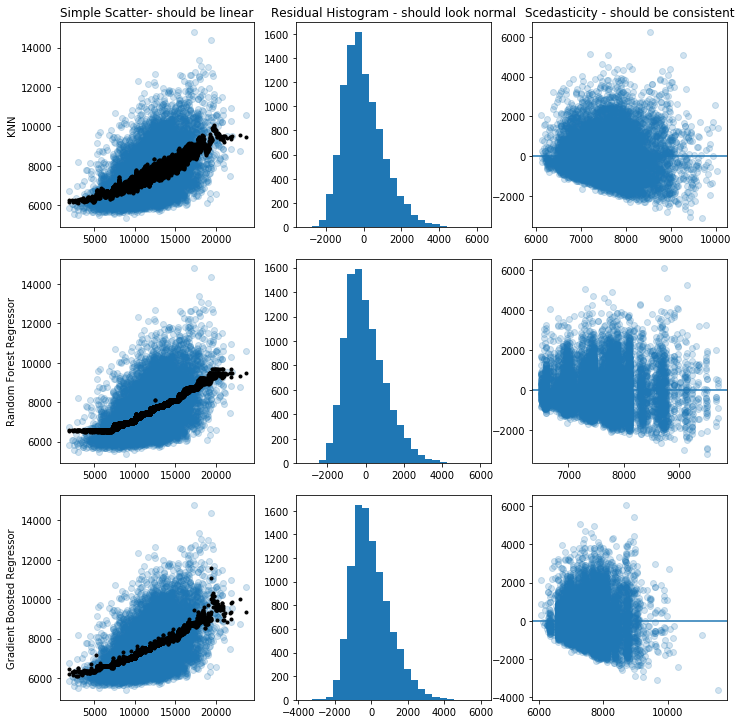

In [25]:
#Let's check how our output looks:
pred = cross_val_predict(knn,pd.DataFrame(x),y,cv=10)
residual = y - pred

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.tight_layout()
plt.subplot(331)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.title('Simple Scatter- should be linear')
plt.ylabel('KNN')
plt.subplot(332)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.subplot(333)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')

pred = cross_val_predict(rfr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(334)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Random Forest Regressor')
plt.subplot(335)
plt.hist(residual, bins=25)
plt.subplot(336)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

pred = cross_val_predict(gbr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(337)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Gradient Boosted Regressor')
plt.subplot(338)
plt.hist(residual, bins=25)
plt.subplot(339)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

plt.show()

In [26]:
# Skewed Target Variable, adjusted:

print("Adjusted :\n")
x = rightskew.df['screenActions']
y = rightskew.df['cube_rt_minSpent']
knn = neighbors.KNeighborsRegressor(n_neighbors=30)
knn.fit(pd.DataFrame(x),y)
scores = cross_val_score(knn,pd.DataFrame(x),y,cv=10)
print("KNN: ",scores)
print("\nAverage Score with 30 neighbors: ",np.mean(scores))
print('\n','-'*40)

rfr = ensemble.RandomForestRegressor(n_estimators=10, max_depth=3)
rfr.fit(pd.DataFrame(x),y)
scores = cross_val_score(rfr,pd.DataFrame(x),y,cv=10)
print("Random Forest Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

gbr = ensemble.GradientBoostingRegressor(loss='ls', learning_rate=.1, max_depth=2, n_estimators=100)
gbr.fit(pd.DataFrame(x),y)
scores = cross_val_score(gbr,pd.DataFrame(x),y,cv=10)
print("Gradient-Boosted Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

Adjusted :

KNN:  [0.25918181 0.2353483  0.24603817 0.23011827 0.20700218 0.2088886
 0.18519621 0.22265618 0.22224841 0.17860234]

Average Score with 30 neighbors:  0.21952804739255485

 ----------------------------------------
Random Forest Regressor:  [0.28417793 0.25823463 0.26333516 0.24880873 0.23962432 0.22604208
 0.20552707 0.23518821 0.23550124 0.21566274]

Average Score:  0.24121021057900024

 ----------------------------------------
Gradient-Boosted Regressor:  [0.2814305  0.25783232 0.26610582 0.25005179 0.24015478 0.22677334
 0.20962951 0.23480399 0.23885576 0.21245586]

Average Score:  0.2418093658508292

 ----------------------------------------


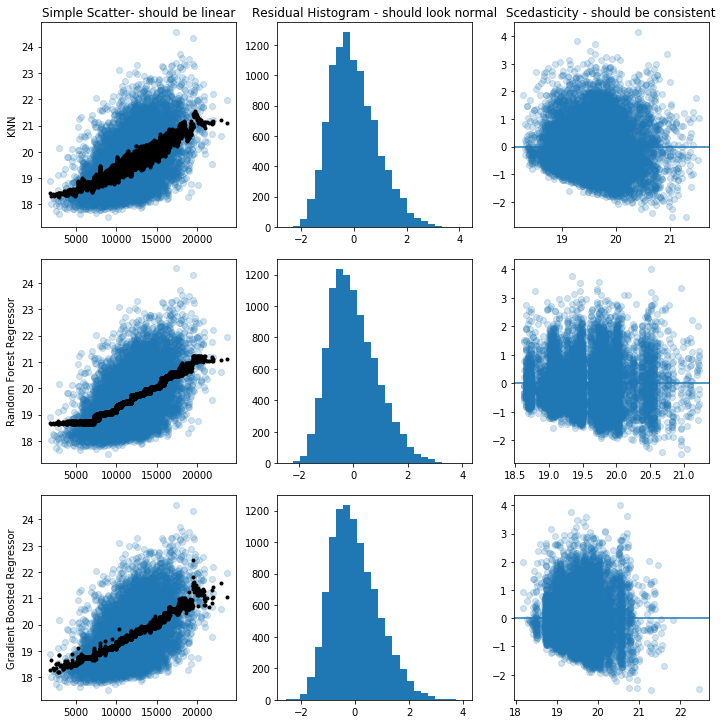

In [27]:
#Let's check how our output looks:
pred = cross_val_predict(knn,pd.DataFrame(x),y,cv=10)
residual = y - pred

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.tight_layout()
plt.subplot(331)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.title('Simple Scatter- should be linear')
plt.ylabel('KNN')
plt.subplot(332)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.subplot(333)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')

pred = cross_val_predict(rfr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(334)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Random Forest Regressor')
plt.subplot(335)
plt.hist(residual, bins=25)
plt.subplot(336)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

pred = cross_val_predict(gbr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(337)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Gradient Boosted Regressor')
plt.subplot(338)
plt.hist(residual, bins=25)
plt.subplot(339)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

plt.show()

# Summary of 1-variable linear regression:
- 30% accurate when both dependent and independent variables are normally distributed
- If the Target Variable has a right skew, we lose 3% of accuracy, and additionally our model loses validity; our residuals tend to be large positives, and are much larger when the input variable is bigger.
- Cube-rooting the target variable to reduce the skew doesn't improve the R-squared score, but it does somewhat normalize residuals and scedasticity, which is useful.

KNN, Random Forest, and Gradient boosted regressors don't necessarily improve on the accuracy of simple linear regression, but they do seem to reduce the effects of a skewed target variable - in particular, Random Forest seems to extrapolate to the tail data better than any other model.


---------
# Attempting Linear Variable Regression with other data types

# 1: Normal Dependent variable,  1 Uniform feature

In [28]:
normal = createSet(targetskew=0, size=10000)
normal.df.head(2)

,hoursSpent,screenActions,picsPerMonth,ownerAge,timesDropped,rooted,os
0,6320.592111,10156,338,43.766463,2,0,Android
1,6535.706056,11275,219,43.534893,1,0,iOS


In [29]:
#sklearn
x = normal.df['picsTaken']
y = normal.df['minSpent']
regr.fit(pd.DataFrame(x),y)
scores = cross_val_score(regr,pd.DataFrame(x),y,cv=10)
print("Fold Scores: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\nCoefficients:', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\n','-'*40)

#statsmodels

linear_formula = 'minSpent ~ picsTaken'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=normal.df).fit()
lm.summary()

Fold Scores:  [0.22864433 0.24491111 0.24665838 0.27091092 0.22685504 0.21502622
 0.21542557 0.20365317 0.24003782 0.25638422]

Average Score:  0.23485067792547518

Coefficients: [6.75012872]

Intercept: 
 4283.182546622458

 ----------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             hoursSpent   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     3085.
Date:                Fri, 28 Dec 2018   Prob (F-statistic):               0.00
Time:                        12:01:14   Log-Likelihood:                -88907.
No. Observations:               10000   AIC:                         1.778e+05
Df Residuals:                    9998   BIC:                         1.778e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     4283.1825     35.197    121.692      0.000    4214.190    4352.176
picsPerMonth     6.7501      0.122     55.547      0.000       6.512       6.988
==============================================================================
Omnibus:                        2.678   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.262   Jarque-Bera (JB):                2.652
Skew:                          -0.030   Prob(JB):                        0.265
Kurtosis:                       3.052   Cond. No.                         580.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

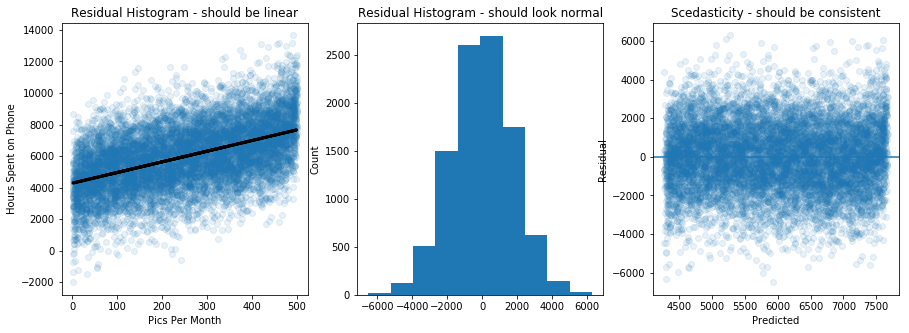

In [30]:
#Let's check how our output looks:
pred = cross_val_predict(regr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.scatter(x,y, alpha=.1)
plt.plot(x, regr.predict(pd.DataFrame(x)), color='black', linewidth=3)
plt.title('Residual Histogram - should be linear')
plt.ylabel('Hours Spent on Phone')
plt.xlabel('Pics Per Month')
plt.subplot(132)
plt.hist(residual)
plt.title('Residual Histogram - should look normal')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.1)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')
plt.show()

# Let's see how other models do

In [31]:
print("NORMAL:\n")
x = normal.df['picsTaken']
y = normal.df['minSpent']
knn = neighbors.KNeighborsRegressor(n_neighbors=30)
knn.fit(pd.DataFrame(x),y)
scores = cross_val_score(knn,pd.DataFrame(x),y,cv=10)
print("KNN: ",scores)
print("\nAverage Score with 30 neighbors: ",np.mean(scores))
print('\n','-'*40)

rfr = ensemble.RandomForestRegressor(n_estimators=10, max_depth=4)
rfr.fit(pd.DataFrame(x),y)
scores = cross_val_score(rfr,pd.DataFrame(x),y,cv=10)
print("Random Forest Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

gbr = ensemble.GradientBoostingRegressor(loss='ls', learning_rate=.1, max_depth=2, n_estimators=100)
gbr.fit(pd.DataFrame(x),y)
scores = cross_val_score(gbr,pd.DataFrame(x),y,cv=10)
print("Gradient-Boosted Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)


#TOO SLOW:
# svm = SVR(kernel='linear')
# svm.fit(pd.DataFrame(x),y)
# scores = cross_val_score(svm,pd.DataFrame(x),y,cv=5)
# print("SVM Regressor: ",scores)
# print("\nAverage Score: ",np.mean(scores))
# print('\n','-'*40)


NORMAL:

KNN:  [0.22562494 0.23902236 0.24281676 0.25831603 0.20909914 0.19474484
 0.18721661 0.19664488 0.2194425  0.25490079]

Average Score with 30 neighbors:  0.22278288526258266

 ----------------------------------------
Random Forest Regressor:  [0.24757269 0.25862212 0.24614048 0.27735588 0.23718933 0.21687659
 0.21504206 0.21772166 0.24193415 0.27063424]

Average Score:  0.24290891868228118

 ----------------------------------------
Gradient-Boosted Regressor:  [0.24486697 0.25833271 0.24727472 0.2782231  0.23669037 0.21685985
 0.21766721 0.21756568 0.24258723 0.269874  ]

Average Score:  0.2429941834181785

 ----------------------------------------


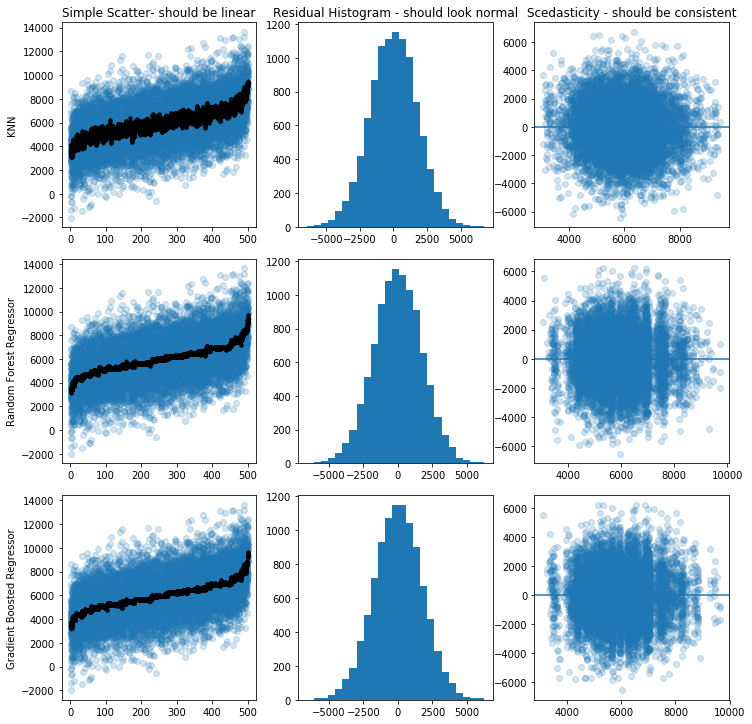

In [32]:
#Let's check how our output looks:
pred = cross_val_predict(knn,pd.DataFrame(x),y,cv=10)
residual = y - pred

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.tight_layout()
plt.subplot(331)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.title('Simple Scatter- should be linear')
plt.ylabel('KNN')
plt.subplot(332)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.subplot(333)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')

pred = cross_val_predict(rfr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(334)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Random Forest Regressor')
plt.subplot(335)
plt.hist(residual, bins=25)
plt.subplot(336)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

pred = cross_val_predict(gbr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(337)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Gradient Boosted Regressor')
plt.subplot(338)
plt.hist(residual, bins=25)
plt.subplot(339)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

plt.show()

# 1: Normal Dependent variable,  1 Gamma feature

In [33]:
normal = createSet(targetskew=0, size=10000)
normal.df.head(2)

,hoursSpent,screenActions,picsPerMonth,ownerAge,timesDropped,rooted,os
0,6801.937881,11857,163,31.662217,1,0,iOS
1,4909.520816,12782,364,24.570165,1,0,Android


In [34]:
#sklearn
x = normal.df['ownerAge']
y = normal.df['minSpent']
regr.fit(pd.DataFrame(x),y)
scores = cross_val_score(regr,pd.DataFrame(x),y,cv=10)
print("Fold Scores: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\nCoefficients:', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\n','-'*40)

#statsmodels

linear_formula = 'minSpent ~ ownerAge'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=normal.df).fit()
lm.summary()

Fold Scores:  [0.23609994 0.20383393 0.22827959 0.23838281 0.26414779 0.23162807
 0.23579266 0.20705077 0.23516295 0.22570776]

Average Score:  0.23060862732998352

Coefficients: [106.60136787]

Intercept: 
 2071.5447120305207

 ----------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             hoursSpent   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     3012.
Date:                Fri, 28 Dec 2018   Prob (F-statistic):               0.00
Time:                        12:01:19   Log-Likelihood:                -88947.
No. Observations:               10000   AIC:                         1.779e+05
Df Residuals:                    9998   BIC:                         1.779e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2071.5447     73.965     28.007      0.000    1926.558    2216.532
ownerAge     106.6014      1.942     54.881      0.000     102.794     110.409
==============================================================================
Omnibus:                        1.670   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.434   Jarque-Bera (JB):                1.651
Skew:                          -0.031   Prob(JB):                        0.438
Kurtosis:                       3.011   Cond. No.                         160.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

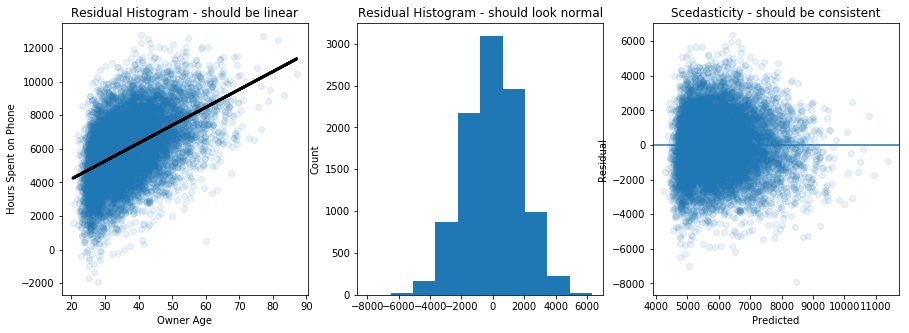

In [35]:
#Let's check how our output looks:
pred = cross_val_predict(regr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.scatter(x,y, alpha=.1)
plt.plot(x, regr.predict(pd.DataFrame(x)), color='black', linewidth=3)
plt.title('Residual Histogram - should be linear')
plt.ylabel('Hours Spent on Phone')
plt.xlabel('Owner Age')
plt.subplot(132)
plt.hist(residual)
plt.title('Residual Histogram - should look normal')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.1)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')
plt.show()

# Let's see how other models do

In [36]:
print("NORMAL:\n")
x = normal.df['ownerAge']
y = normal.df['minSpent']
knn = neighbors.KNeighborsRegressor(n_neighbors=30)
knn.fit(pd.DataFrame(x),y)
scores = cross_val_score(knn,pd.DataFrame(x),y,cv=10)
print("KNN: ",scores)
print("\nAverage Score with 30 neighbors: ",np.mean(scores))
print('\n','-'*40)

rfr = ensemble.RandomForestRegressor(n_estimators=10, max_depth=4)
rfr.fit(pd.DataFrame(x),y)
scores = cross_val_score(rfr,pd.DataFrame(x),y,cv=10)
print("Random Forest Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

gbr = ensemble.GradientBoostingRegressor(loss='ls', learning_rate=.1, max_depth=2, n_estimators=100)
gbr.fit(pd.DataFrame(x),y)
scores = cross_val_score(gbr,pd.DataFrame(x),y,cv=10)
print("Gradient-Boosted Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)


#TOO SLOW:
# svm = SVR(kernel='linear')
# svm.fit(pd.DataFrame(x),y)
# scores = cross_val_score(svm,pd.DataFrame(x),y,cv=5)
# print("SVM Regressor: ",scores)
# print("\nAverage Score: ",np.mean(scores))
# print('\n','-'*40)


NORMAL:

KNN:  [0.21473351 0.1841097  0.21947259 0.23696135 0.27139218 0.23008068
 0.21577804 0.20231868 0.21601309 0.19233057]

Average Score with 30 neighbors:  0.21831903874047542

 ----------------------------------------
Random Forest Regressor:  [0.2403787  0.20634931 0.24622698 0.24674434 0.28364235 0.24237741
 0.24436629 0.21709176 0.2365179  0.23821672]

Average Score:  0.24019117654751496

 ----------------------------------------
Gradient-Boosted Regressor:  [0.24498743 0.21048898 0.24578737 0.24915716 0.28754825 0.24042309
 0.24465832 0.21819468 0.23093518 0.23900296]

Average Score:  0.2411183405908493

 ----------------------------------------


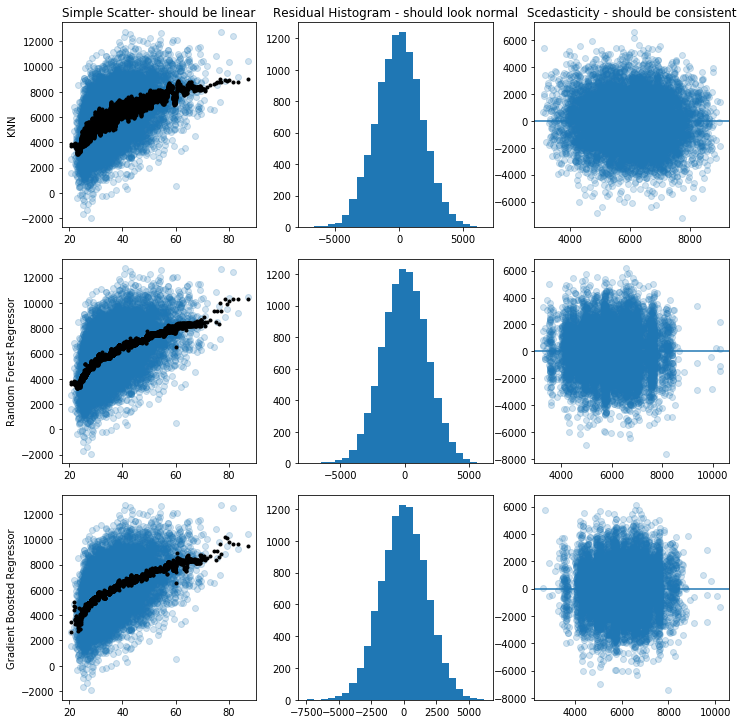

In [37]:
#Let's check how our output looks:
pred = cross_val_predict(knn,pd.DataFrame(x),y,cv=10)
residual = y - pred

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.tight_layout()
plt.subplot(331)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.title('Simple Scatter- should be linear')
plt.ylabel('KNN')
plt.subplot(332)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.subplot(333)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')

pred = cross_val_predict(rfr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(334)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Random Forest Regressor')
plt.subplot(335)
plt.hist(residual, bins=25)
plt.subplot(336)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

pred = cross_val_predict(gbr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(337)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Gradient Boosted Regressor')
plt.subplot(338)
plt.hist(residual, bins=25)
plt.subplot(339)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

plt.show()

# Next Ideas?

- smaller samples?
- Central Limit Theorem?
- error measurement?
- switch to logistic regression? Confusion matrix, ROC
- added outliers?

In [38]:
# Central Limit Theorem:
#large data set with no normal distribution
#sample over and over, the means will be normally distributed

# Central Limit Theorem demonstration

In [39]:
clt = createSet(size=100000, targetskew=-10)

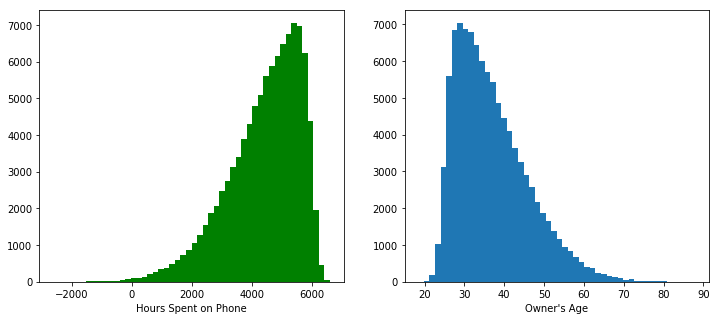

In [40]:
plt.figure(figsize=[12,5])
plt.subplot(121)
plt.hist(clt.df.minSpent, bins=50, color='g')
plt.xlabel('Hours Spent on Phone')
plt.subplot(122)
plt.hist(clt.df.ownerAge, bins=50)
plt.xlabel('Owner\'s Age')
plt.show()

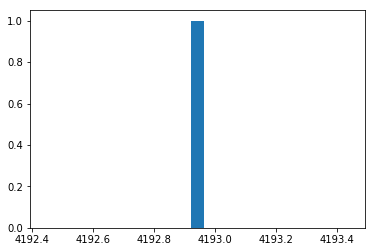

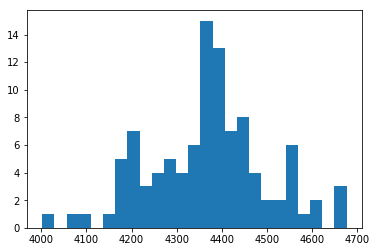

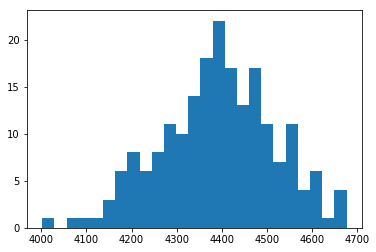

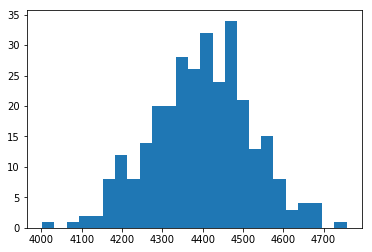

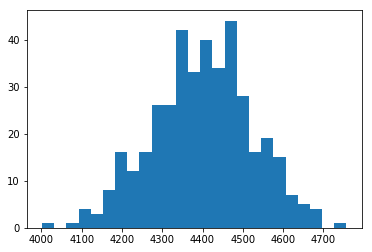

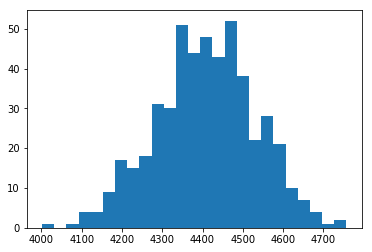

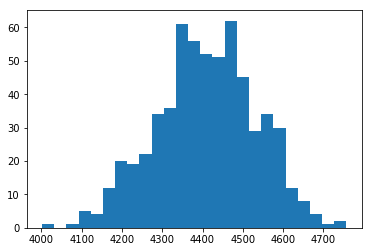

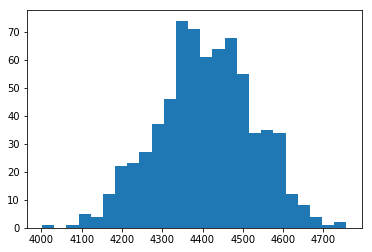

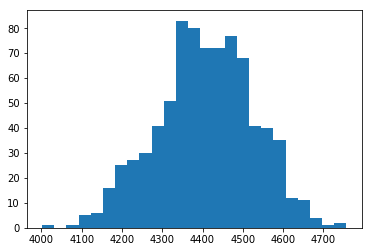

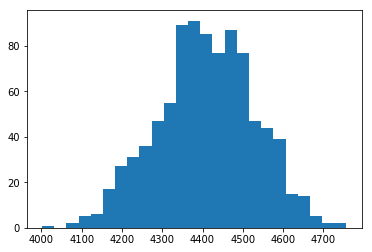

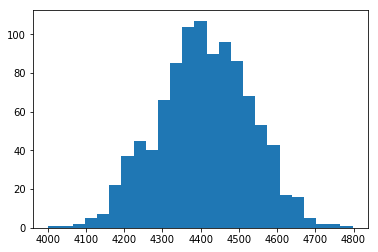

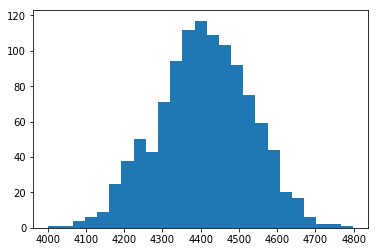

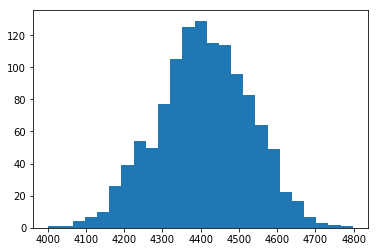

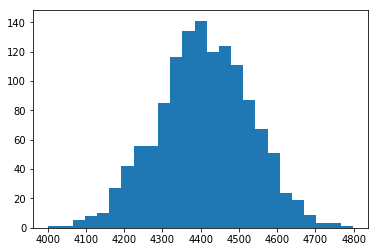

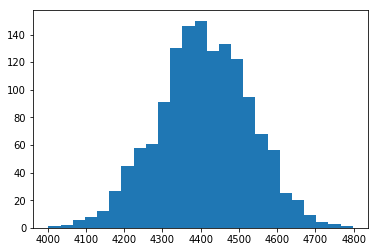

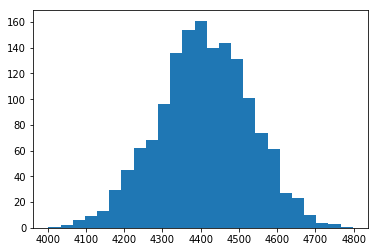

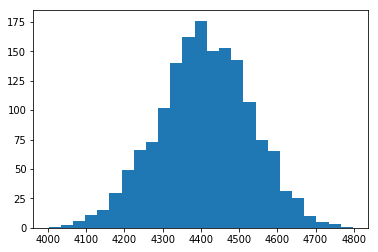

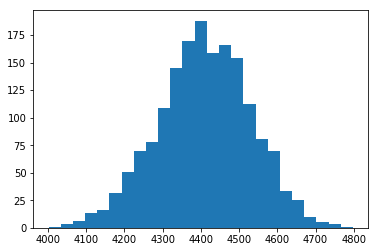

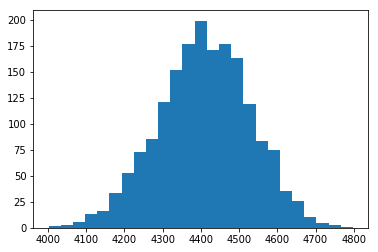

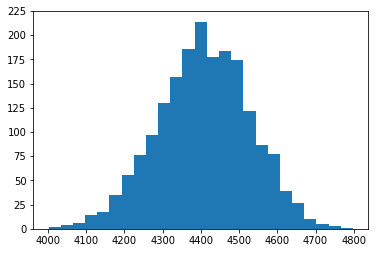

In [41]:
sampleMeans = []

for i in range (2000):
    samples = clt.df.sample(100, replace=True,axis=0)
    sMean = np.mean(samples.minSpent)
    sampleMeans.append(sMean)
    if i % 100 == 0:
        plt.hist(sampleMeans, bins=25)
        plt.show()
    

# Law of Large Numbers

In [64]:
loln = createSet(targetskew=0)

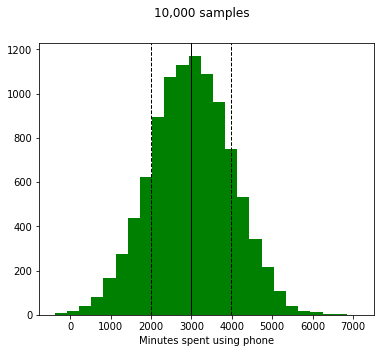

In [109]:

fig = plt.figure(figsize=[6,5])
fig.patch.set_facecolor('white')
fig.suptitle("10,000 samples")
plt.hist(loln.df.minSpent, color='g',bins=25)
plt.axvline(loln.df.minSpent.mean(), color='k', linestyle='solid', linewidth=1)
plt.axvline(loln.df.minSpent.mean() - loln.df.minSpent.std(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(loln.df.minSpent.mean() + loln.df.minSpent.std(), color='k', linestyle='dashed', linewidth=1)
plt.xlabel('Minutes spent using phone')
plt.show()

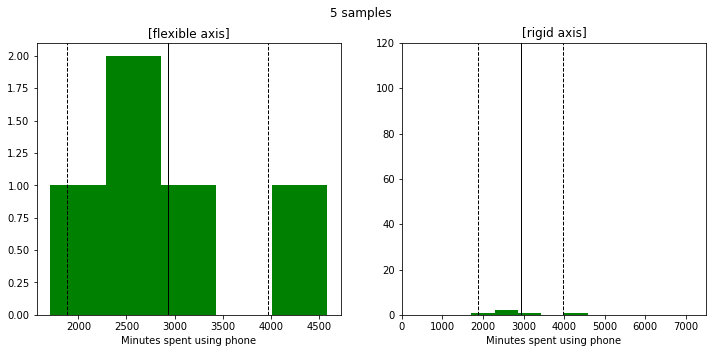

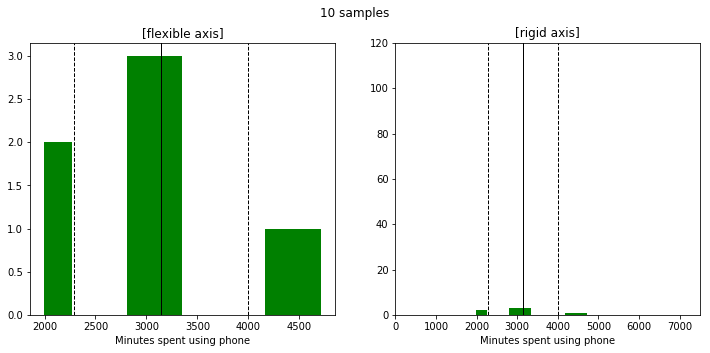

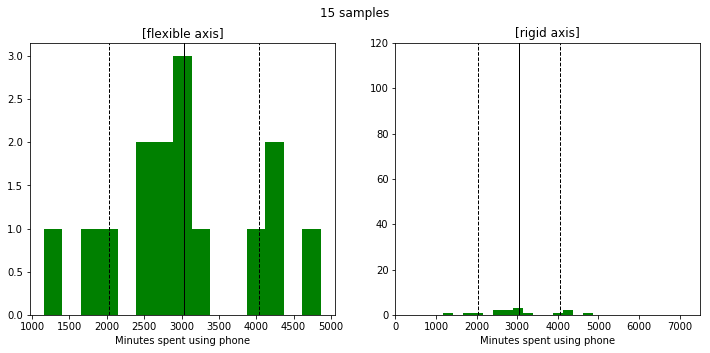

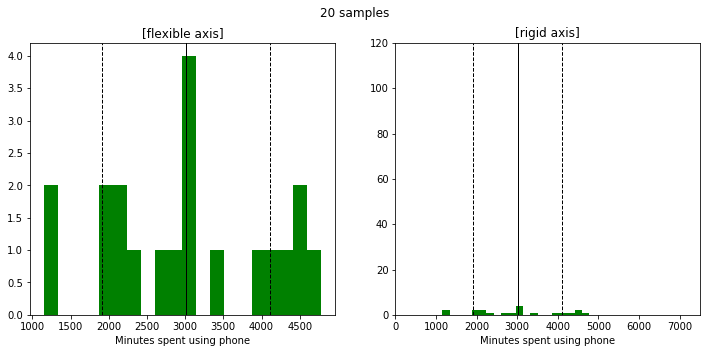

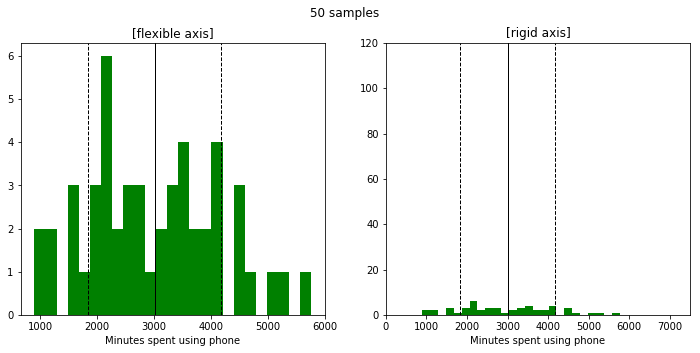

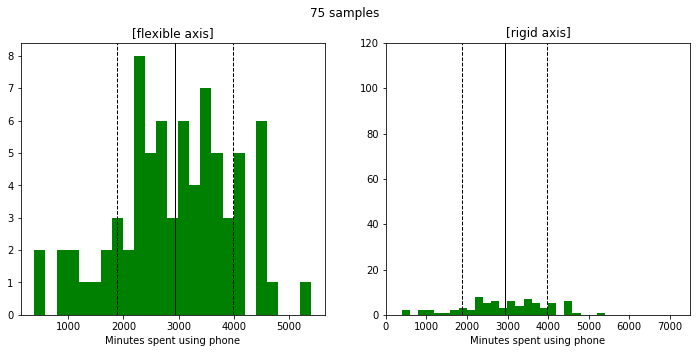

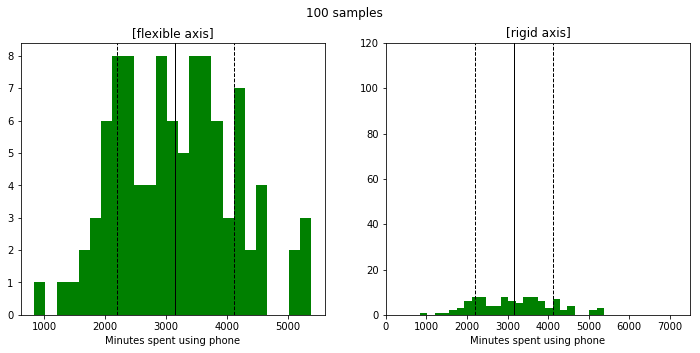

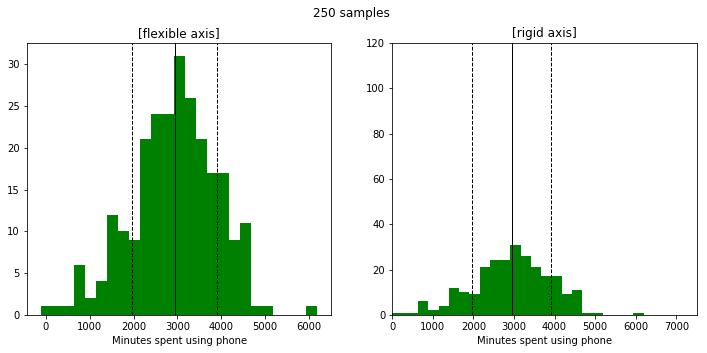

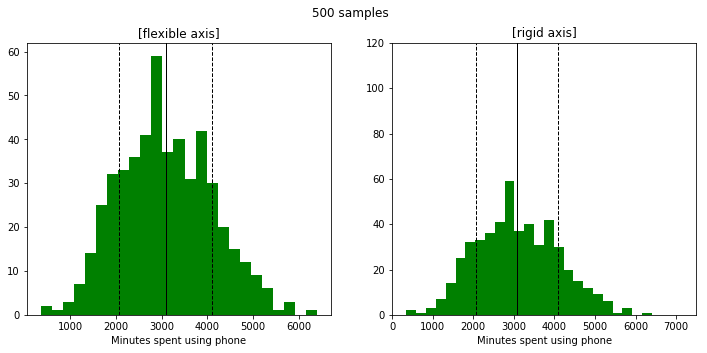

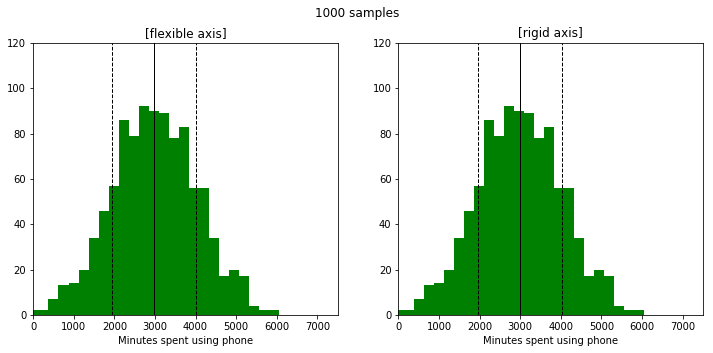

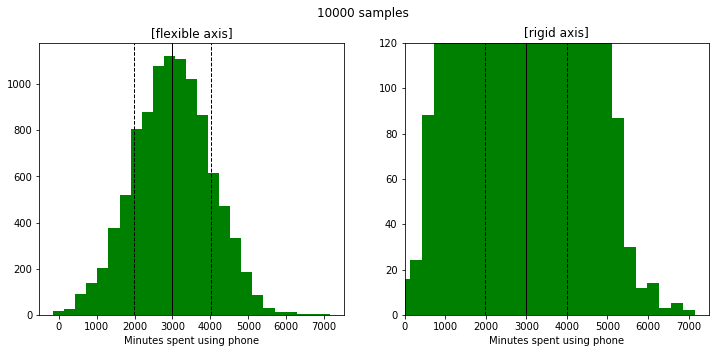

In [110]:
sizes = [5,10,15,20,50, 75, 100,250,500,1000, 10000]
for i in sizes:
    samples = loln.df.sample(i,replace=True, axis=0)
    fig = plt.figure(figsize=[12,5])
    fig.patch.set_facecolor('white')
    fig.suptitle(str(i) + " samples")
    plt.subplot(121)
    plt.xlabel('Minutes spent using phone')
    plt.title('[flexible axis]')
    plt.hist(samples.minSpent, color='green', bins=min(i,25))
    plt.axvline(samples.minSpent.mean(), color='k', linestyle='solid', linewidth=1)
    plt.axvline(samples.minSpent.mean() - samples.minSpent.std(), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(samples.minSpent.mean() + samples.minSpent.std(), color='k', linestyle='dashed', linewidth=1)
    if i == 1000:
        plt.ylim(0,120)
        plt.xlim(0,7500)
    plt.subplot(122)
    plt.title('[rigid axis]')
    plt.xlabel('Minutes spent using phone')
    plt.axvline(samples.minSpent.mean(), color='k', linestyle='solid', linewidth=1)
    plt.axvline(samples.minSpent.mean() - samples.minSpent.std(), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(samples.minSpent.mean() + samples.minSpent.std(), color='k', linestyle='dashed', linewidth=1)
    plt.ylim(0,120)
    plt.xlim(0,7500)
    plt.hist(samples.minSpent, color='green', bins=min(i,25))
    plt.show()

work  in bayesian vs frequentist thinking
p values, priors etc.

logistic regression (over/under x hours?) to discuss ROC